## Data collection

In [ ]:
!unzip -qq IAM_Words.zip
!

In [ ]:
!mkdir dataset
!mkdir dataset/words
!tar -xf IAM_Words/words.tgz -C dataset/words
!mv IAM_Words/words.txt dataset

In [ ]:
!head -50 dataset/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 118

## Imports

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [ ]:
dataset_directory = "dataset"
collected_words = []

words_data = open(f"{dataset_directory}/words.txt", "r").readlines()
for entry in words_data:
    if entry.startswith("#"):
        continue
    if entry.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        collected_words.append(entry)

len(collected_words)

np.random.shuffle(collected_words)

In [ ]:
train_split_index  = int(0.9 * len(collected_words))
train_data  = collected_words[:train_split_index ]
test_data = collected_words[train_split_index :]

validation_split_index = int(0.5 * len(test_data))
val_data = test_data[:validation_split_index]
test_data = test_data[validation_split_index:]

assert len(collected_words) == len(train_data ) + len(val_data) + len(test_data)

print(f"The training data size: {len(train_data )}")
print(f"The validation data size: {len(val_data)}")
print(f"The test data size: {len(test_data)}")

The training data size: 86810
The validation data size: 4823
The test data size: 4823


In [ ]:
path_inf_img = os.path.join(dataset_directory, "words")



def retrieve_img_labels_and_paths(data_samples):
    image_paths = []
    processed_samples = []
    for index, line in enumerate(data_samples):
        cleaned_line = line.strip().split(" ")


        filename = cleaned_line[0]
        first_part = filename.split("-")[0]
        second_part = filename.split("-")[1]
        full_path = os.path.join(
            path_inf_img, first_part, f"{first_part}-{second_part}", f"{filename}.png"
        )
        if os.path.getsize(full_path):
            image_paths.append(full_path)
            processed_samples.append(line.split("\n")[0])

    return image_paths, processed_samples


train_img_paths, train_sample_labels = retrieve_img_labels_and_paths(train_data )
validation_img_paths, validation_sample_labels = retrieve_img_labels_and_paths(val_data)
test_img_paths, test_sample_labels = retrieve_img_labels_and_paths(test_data)

In [ ]:
cleaned_train_labels = []
characters = set()
longest_label_length = 0

for sample_label in train_sample_labels:
    cleaned_label = sample_label.split(" ")[-1].strip()
    for character in cleaned_label:
        characters.add(character)
    longest_label_length = max(longest_label_length, len(cleaned_label))
    cleaned_train_labels.append(cleaned_label)

sorted_characters = sorted(list(characters))

print("Maximum length: ", longest_label_length)
print("Vocab size: ", len(sorted_characters))

cleaned_train_labels[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [ ]:

def extract_clean_labels(raw_labels):
    refined_labels = []
    for label in raw_labels:
        refined_label = label.split(" ")[-1].strip()
        refined_labels.append(refined_label)
    return refined_labels


val_cleaned_labels = extract_clean_labels(validation_sample_labels)
test_cleaned_labels = extract_clean_labels(test_sample_labels)

## Building the character vocabulary

In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
character_to_index = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=character_to_index.get_vocabulary(), mask_token=None, invert=True
)

## Resizing images without distortion

In [ ]:
def distortionFree_resize(image, target_size):
    target_width, target_height = target_size
    # Resize the image to target size, maintaining the aspect ratio
    image = tf.image.resize(image, (target_height, target_width), preserve_aspect_ratio=True)

    # Calculate padding needs for height and width
    padding_height = target_height - tf.shape(image)[0]
    padding_width = target_width - tf.shape(image)[1]

    # Adjust padding to be symmetric if needed
    if padding_height % 2 != 0:
        pad_top = padding_height // 2
        pad_bottom = pad_top + 1
    else:
        pad_top = pad_bottom = padding_height // 2

    if padding_width % 2 != 0:
        pad_left = padding_width // 2
        pad_right = pad_left + 1
    else:
        pad_left = pad_right = padding_width // 2

    # Apply symmetric padding to the image
    image = tf.pad(
        image,
        paddings=[[pad_top, pad_bottom],[pad_left, pad_right],[0, 0],]

    )

    # Reorient the image
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
batch_size = 64
padding_token = 99
desired_width = 128
desired_height = 32


def image_preprocessing(image_path, target_size=(desired_width, desired_height)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = distortionFree_resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize the pixel values
    return img


def encode_label(text_label):
    encoded_label = character_to_index(tf.strings.unicode_split(text_label, 'UTF-8'))
    label_length = tf.shape(encoded_label)[0]
    padding_needed = longest_label_length - label_length
    encoded_label = tf.pad(encoded_label, paddings=[[0, padding_needed]], constant_values=padding_token)
    return encoded_label


def prepare_image_label_pairs(image_filepath, text_label):
    img = image_preprocessing(image_filepath)
    label = encode_label(text_label)
    return {"image": img, "label": label}

def setup_dataset(paths, text_labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, text_labels)).map(
        prepare_image_label_pairs, num_parallel_calls=AUTOTUNE
    )
    return ds.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [ ]:
train_ds = setup_dataset(train_img_paths, cleaned_train_labels)
validation_ds = setup_dataset(validation_img_paths, val_cleaned_labels)
test_ds = setup_dataset(test_img_paths, test_cleaned_labels)

## Visualization

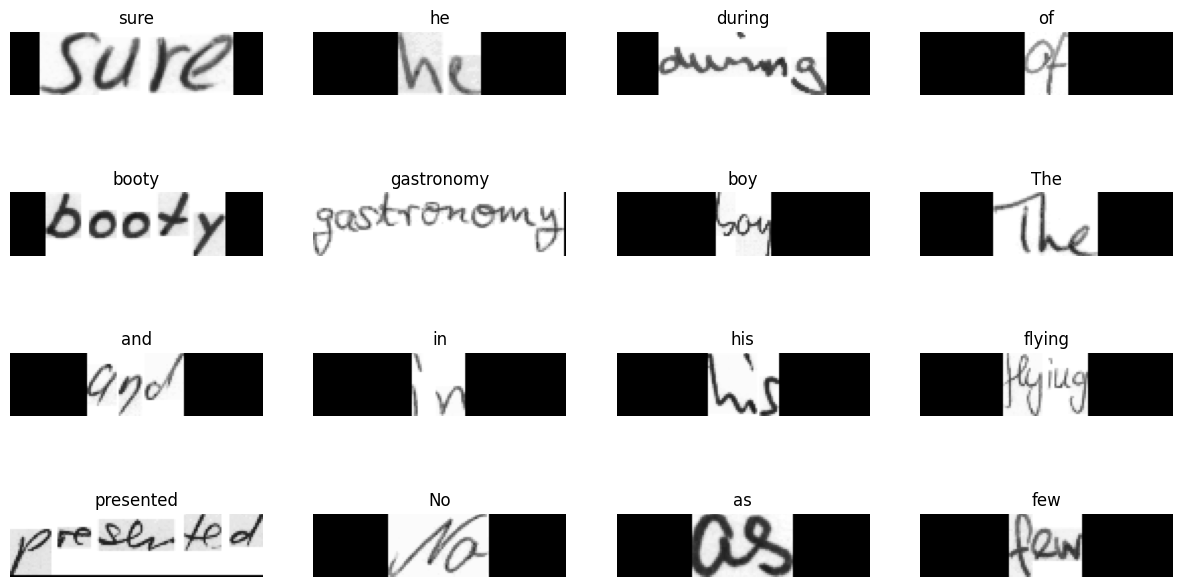

In [ ]:
for batch in train_ds.take(1):
    images_batch, labels_batch = batch["image"], batch["label"]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 8))

    for idx in range(16):
        current_image = images_batch[idx]
        current_image = tf.image.flip_left_right(current_image)
        current_image = tf.transpose(current_image, perm=[1, 0, 2])
        current_image = (current_image * 255.0).numpy().clip(0, 255).astype(np.uint8)
        current_image = current_image[:, :, 0]  # Assuming grayscale for visualization


        current_label = labels_batch[idx]
        valid_indices = tf.gather(current_label, tf.where(tf.not_equal(current_label, padding_token)))

        decoded_label = tf.strings.reduce_join(num_to_char(valid_indices))
        decoded_label = decoded_label.numpy().decode("utf-8")


        ax = axes[idx // 4, idx % 4]
        ax.imshow(current_image, cmap="gray")
        ax.set_title(decoded_label)
        ax.axis("off")


plt.show()

## Model

In [ ]:
class CustomCTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super(CustomCTCLayer, self).__init__(name=name)
        self.ctc_loss_fn = keras.backend.ctc_batch_cost

    def call(self, true_labels, predictions):
        batch_size = tf.cast(tf.shape(true_labels)[0], dtype="int64")
        pred_length = tf.cast(tf.shape(predictions)[1], dtype="int64")
        label_length = tf.cast(tf.shape(true_labels)[1], dtype="int64")

        pred_length = pred_length * tf.ones(shape=(batch_size, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_size, 1), dtype="int64")
        loss = self.ctc_loss_fn(true_labels, predictions, pred_length, label_length)
        self.add_loss(loss)

        return predictions

def construct_model():
    # Define model inputs
    input_image = keras.Input(shape=(desired_width, desired_height, 1), name="image")
    target_labels = keras.Input(shape=(None,), name="label")

    # Convolutional blocks
    conv1 = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_image)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(conv1)
    pool1 = keras.layers.MaxPooling2D((2, 2), name="pool1")(conv2)
    conv3 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3")(pool1)
    conv3_dropout = keras.layers.Dropout(0.2)(conv3)
    conv4 = keras.layers.Conv2D(1024, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv4")(conv3_dropout)
    pool2 = keras.layers.MaxPooling2D((2, 2), name="pool2")(conv4)
    conv5 = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv5")(pool2)

    # Reshaping for RNN layers
    reshaped_features = keras.layers.Reshape(((desired_width // 4), (desired_height // 4) * 64), name="reshape")(conv5)
    dense1 = keras.layers.Dense(64, activation="relu", name="dense1")(reshaped_features)
    dropout = keras.layers.Dropout(0.2)(dense1)

    # RNN layers
    bi_lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True, dropout=0.3))(dropout)
    bi_lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True, dropout=0.25))(bi_lstm1)
    bi_lstm3 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.2))(bi_lstm2)

    # Output layer
    output_layer = keras.layers.Dense(len(character_to_index.get_vocabulary()) + 2, activation="softmax", name="output_layer")(bi_lstm3)

    # Add the custom CTC layer to calculate the loss
    ctc_output = CustomCTCLayer(name="ctc_layer")(target_labels, output_layer)

    model = keras.models.Model(inputs=[input_image, target_labels], outputs=ctc_output, name="ocr_model")

    model.compile(optimizer=keras.optimizers.Adam())

    return model

ocr_model = construct_model()
ocr_model.summary()


Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 128, 32, 128)         36992     ['Conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 128)          0         ['Conv2[0][0]']               
                                                                                          

## Evaluation metric

In [ ]:
valid_images = []
valid_labels = []

for batch_data in validation_ds:
    valid_images.append(batch_data["image"])
    valid_labels.append(batch_data["label"])

In [ ]:
def measure_edit_distance(ground_truth, model_predictions):
    converted_labels = tf.cast(tf.sparse.from_dense(ground_truth), dtype=tf.int64)

    prediction_length = np.ones(model_predictions.shape[0]) * model_predictions.shape[1]
    decoded_outputs = keras.backend.ctc_decode(model_predictions, input_length=prediction_length, greedy=True)[0][0][:, :longest_label_length]
    converted_predictions = tf.cast(tf.sparse.from_dense(decoded_outputs), dtype=tf.int64)

    distances = tf.edit_distance(converted_predictions, converted_labels, normalize=False)
    average_distance = tf.reduce_mean(distances)
    return average_distance

class DistanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, model_predictor):
        super(DistanceEvaluationCallback, self).__init__()
        self.model_predictor = model_predictor

    def on_epoch_end(self, epoch, logs=None):
        computed_distances = []

        for index in range(len(valid_images)):
            true_labels = valid_labels[index]
            model_output = self.model_predictor.predict(valid_images[index])
            computed_distances.append(measure_edit_distance(true_labels, model_output).numpy())

        average_distance = np.mean(computed_distances)
        print(f"Mean edit distance at epoch {epoch + 1}: {average_distance:.4f}")


## Training

In [ ]:
num_epochs = 50
save_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_output.h5", save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

ocr_model = construct_model()
predict_model = keras.models.Model(
    inputs=ocr_model.get_layer("image").input,
    outputs=ocr_model.get_layer("output_layer").output
)
distance_metric_callback = DistanceEvaluationCallback(predict_model)

training_history = ocr_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    callbacks=[save_checkpoint, stop_early, distance_metric_callback],
)


Epoch 1/50
   6/1357 [..............................] - ETA: 5:28 - loss: 47.7543

1357/1357 [==============================] - ETA: 0s - loss: 11.8077

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Mean edit distance at epoch 1: 19.9995
1357/1357 [==============================] - 425s 293ms/step - loss: 11.8077 - val_loss: 9.0297
Epoch 2/50
1/1 [==============================] - 0s 47ms/step
Mean edit distance at epoch 2: 18.0808
1357/1357 [==============================] - 380s 280ms/step - loss: 6.1929 - val_loss: 3.6076
Epoch 3/50
1/1 [==============================] - 0s 59ms/step
Mean edit distance at epoch 3: 17.6554
1357/1357 [==============================] - 383s 282ms/step - loss: 3.0964 - val_loss: 2.4889
Epoch 4/50
1/1 [==============================] - 0s 47ms/step
Mean edit distance at epoch 4: 17.4277
1357/1357 [==============================] - 383s 282ms/step - loss: 2.2514 - val_loss: 1.9121
Epoch 5/50
1/1 [==============================] - 0s 48ms/step
Mean edit distance at epoch 5: 17.2861
1357/1357 [==============================] - 382s 282ms/step - loss: 1.8758 - val_loss: 1.5720
Epoch 6/50
1/1 [===========

## Inference

Batch size:  2
Shape of second image in batch:  (128, 32, 1)
2/2 [==============================] - 0s 57ms/step
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)
Image shape:  (128, 32, 1)


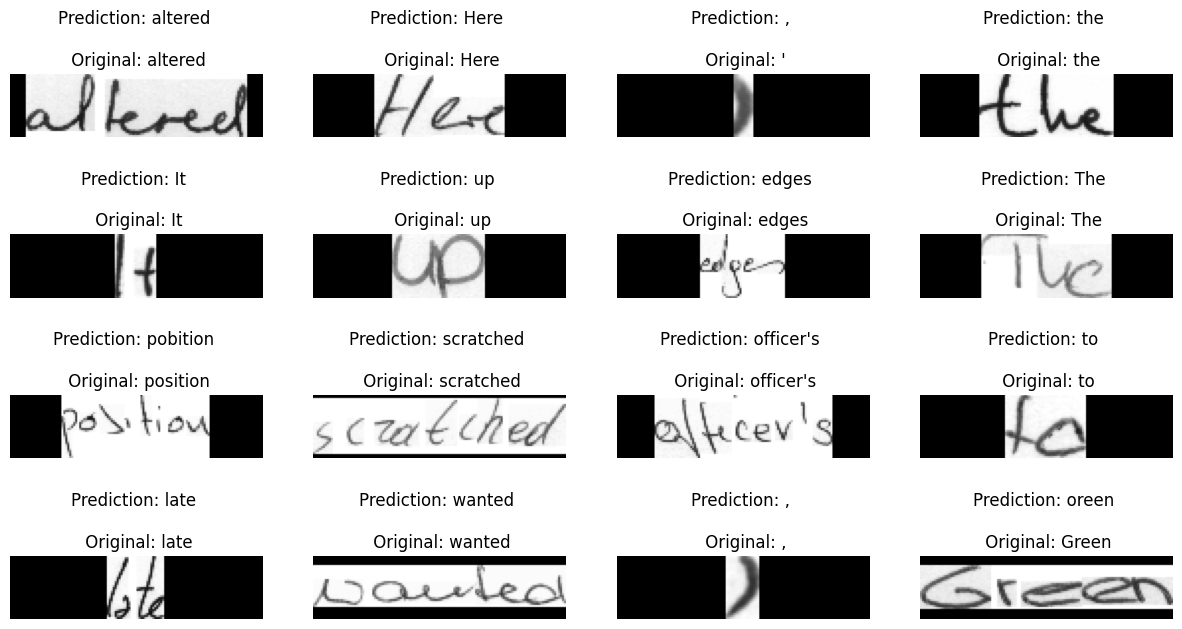

In [ ]:
def decode_predictions(predictions):
    sequence_length = np.ones(predictions.shape[0]) * predictions.shape[1]
    decoded_results = keras.backend.ctc_decode(predictions, input_length=sequence_length, greedy=True)[0][0][:, :longest_label_length]

    textual_outputs = []
    for item in decoded_results:
        item = tf.gather(item, tf.where(tf.math.not_equal(item, -1)))
        item = tf.strings.reduce_join(num_to_char(item)).numpy().decode("utf-8")
        textual_outputs.append(item)
    return textual_outputs


for sample in test_ds.take(1):
    images, labels = sample["image"], sample["label"]
    print("Batch size: ", len(sample))
    print("Shape of second image in batch: ", images[1].shape)

    _, plot_grid = plt.subplots(4, 4, figsize=(15, 8))

    predictions = predict_model.predict(images)
    decoded_predictions = decode_predictions(predictions)

    for index in range(16):
        current_image = images[index]
        print("Image shape: ", current_image.shape)
        current_image = tf.image.flip_left_right(current_image)
        current_image = tf.transpose(current_image, perm=[1, 0, 2])
        current_image = (current_image * 255.0).numpy().clip(0, 255).astype(np.uint8)
        current_image = current_image[:, :, 0]  # Assuming a single-channel (grayscale) image

        current_label = labels[index]
        relevant_indices = tf.gather(current_label, tf.where(tf.math.not_equal(current_label, padding_token)))
        current_label = tf.strings.reduce_join(num_to_char(relevant_indices))
        current_label = current_label.numpy().decode("utf-8")

        image_title = f"Prediction: {decoded_predictions[index]} \n\n Original: {current_label}"
        plot_grid[index // 4, index % 4].imshow(current_image, cmap='gray')
        plot_grid[index // 4, index % 4].set_title(image_title)
        plot_grid[index // 4, index % 4].axis('off')

plt.show()

In [ ]:
total_predictions = 0
successful_predictions = 0


for sample in test_ds:
    images, labels = sample["image"], sample["label"]

    predictions = predict_model.predict(images)
    decoded_texts = decode_predictions(predictions)

    for idx in range(len(labels)):
        true_label = labels[idx]
        valid_indices = tf.gather(true_label, tf.where(tf.math.not_equal(true_label, padding_token)))

        true_label = tf.strings.reduce_join(num_to_char(valid_indices))
        true_label = true_label.numpy().decode("utf-8")

        total_predictions += 1
        if true_label == decoded_texts[idx]:
            successful_predictions += 1


print("Total evaluations: ", total_predictions)
print("Accurate predictions: ", successful_predictions)


accuracy_percentage = (successful_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage}%.")

1/1 [==============================] - 0s 55ms/step
Total evaluations:  4823
Accurate predictions:  3870
Accuracy: 80.24051420277836%.


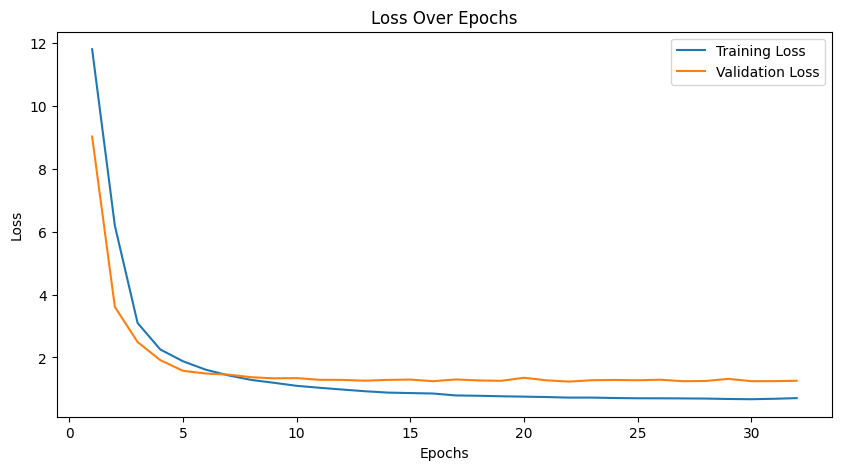

In [ ]:
training_loss = training_history.history["loss"]
validation_loss = training_history.history["val_loss"]

epoch_list = list(range(1, len(training_loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epoch_list, training_loss, label="Training Loss")
plt.plot(epoch_list, validation_loss, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
ocr_model.save('content/models/BILSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
